In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving tour_logs_train.csv to tour_logs_train (5).csv


In [ ]:
td=pd.read_csv("tour_logs_train.csv")

# **Data Overview :**

In [ ]:
td.head()

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55


# **Feature Engineering(Transformation):**


**Show_DateTime   into  Show_Date  and   Show_Time**

In [ ]:
td["Show_DateTime_Clean"] = pd.to_datetime(
    td["Show_DateTime"],
    errors="coerce"
)
m = td["Show_DateTime_Clean"].isna()

td.loc[m, "Show_DateTime_Clean"] = pd.to_datetime(
    td.loc[m, "Show_DateTime"],
    format="%d/%m/%Y %I:%M %p",
    errors="coerce"
)
m2 = td["Show_DateTime_Clean"].isna()

td.loc[m2, "Show_DateTime_Clean"] = pd.to_datetime(
    td.loc[m2, "Show_DateTime"],
    format="%m-%d-%Y %H:%M",
    errors="coerce"
)

td["Show_Date"]=td["Show_DateTime_Clean"].dt.date
td["Show_Time"]=td["Show_DateTime_Clean"].dt.time
td.head()

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy,Show_DateTime_Clean,Show_Date,Show_Time
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96,2024-03-07 21:00:00,2024-03-07,21:00:00
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42,2024-09-05 22:00:00,2024-09-05,22:00:00
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58,2024-03-09 15:00:00,2024-03-09,15:00:00
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00,2024-07-08 08:00:00,2024-07-08,08:00:00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55,2024-04-26 17:00:00,2024-04-26,17:00:00


# **Feature Engineering(Threshold):**
**Show_Time into Time_Label**

In [ ]:
td["Time_Label"]=''
for i in range(len(td)):
  x=td.loc[i,"Show_DateTime"]
  y=td.loc[i,"Show_DateTime_Clean"]

  if x in ["Morning","Afternoon","Evening","Late Night"]:
    td.loc[i,"Time_Label"]=x

  elif pd.notnull(y):
    hour=y.hour

    if hour>=5 and hour<=11:
      td.loc[i,"Time_Label"]="Morning"
    elif hour>=12 and hour<=16:
      td.loc[i,"Time_Label"]="Afternoon"
    elif hour>=17 and hour<=20:
      td.loc[i,"Time_Label"]="Evening"
    else:
      td.loc[i,"Time_Label"]="Late Night"
  else:
    td.loc[i,"Time_Label"]=None
td[["Show_DateTime","Show_DateTime_Clean","Time_Label"]].head()

,Show_DateTime,Show_DateTime_Clean,Time_Label
0,2024-03-07 21:00:00,2024-03-07 21:00:00,Late Night
1,2024-09-05 22:00:00,2024-09-05 22:00:00,Late Night
2,2024-03-09 15:00:00,2024-03-09 15:00:00,Afternoon
3,08/07/2024 08:00 AM,2024-07-08 08:00:00,Morning
4,2024-04-26 17:00:00,2024-04-26 17:00:00,Evening


## **Dealing With Missing Time_Labels:**

In [ ]:
missing_time=td[td["Time_Label"].isna()]
missing_time["Venue_ID"].value_counts()



,count
Venue_ID,
V_Beta,93


In [ ]:
beta_mode = td[td["Venue_ID"] == "V_Beta"]["Time_Label"].mode()[0]
print(f"{beta_mode}")
mask = (td["Venue_ID"] == "V_Beta") & (td["Time_Label"].isna())
td.loc[mask, "Time_Label"] = beta_mode
missing_count = td[td["Venue_ID"] == "V_Beta"]["Time_Label"].isna().sum()

Late Night


In [ ]:
td[(td["Venue_ID"]=="V_Beta") & (td["Time_Label"].isna())]["Time_Label"]

,Time_Label


# **Cleaning Data of Ticket_Price column:**
**Making a new column(Ticket_Price_Clean)**

In [ ]:
import re
import pandas as pd

ex_rate = {
    "$": 1.0,
    "€": 1.09,
    "£": 1.27
}

td["Ticket_Price_Clean"] = None

for i in td.index: # Changed to iterate over actual index
    p = td.loc[i, "Ticket_Price"]

    if pd.isnull(p):
        continue

    p = str(p)

    sym_chec = False
    amount = None

    for s in ex_rate:
        if s in p:
            sym_chec = True

            m = re.search(r'\d+\.?\d*', p)
            if m:
                amount = float(m.group()) * ex_rate[s]
            break

    if not sym_chec:

        m = re.search(r'\d+\.?\d*', p)
        if m:
            amount = float(m.group()) * ex_rate["$"]

    if amount is not None:
        td.loc[i, "Ticket_Price_Clean"] = float(amount)
    if p=="Free":
        td.loc[i, "Ticket_Price_Clean"] = 0.0

# **Cleaning Crowd_Size column**
Capping all the values above 1000 to 1000(Maxm seat capacity)

Replacing all impossible values to the Median of the data..

In [ ]:
import numpy as np
good_data_condition = (td["Crowd_Size"] > 0) & (td["Crowd_Size"] <= 1000)
valid_median = td.loc[good_data_condition, "Crowd_Size"].median()

print(f"The typical crowd size (Median) is: {valid_median}")

def clean_crowd_size(x):

    if x > 1000:
        return 1000

    elif x <= 0:
        return valid_median

    else:
        return x


td["Crowd_Size"] = td["Crowd_Size"].apply(clean_crowd_size)
td["Crowd_Size"]= td["Crowd_Size"].fillna(valid_median)

print("Min Crowd:", td["Crowd_Size"].min())
print("Max Crowd:", td["Crowd_Size"].max())

The typical crowd size (Median) is: 530.0
Min Crowd: 100.0
Max Crowd: 1000.0


# **Cleaning of Volume_Level Column:**
**Replacing all the None values and 0 values to 11 (As per Scribble)**

In [ ]:
td["Volume_Level"].unique()

array([ 5.,  2.,  1., 10.,  8.,  3.,  4.,  9., 11.,  7.,  0., nan,  6.,
       99., -5.])

In [ ]:
mask_alpha_volume = (
    (td["Venue_ID"] == "V_Alpha") &
    (   (td["Volume_Level"]>=11) |
        (td["Volume_Level"].isna()) |
        (td["Volume_Level"] <= 0)
    )
)
td.loc[mask_alpha_volume,"Volume_Level"]=5
print("Volume_Level for V_Alpha after cleaning:")
print(td[td["Venue_ID"] == "V_Alpha"]["Volume_Level"].value_counts().sort_index())

Volume_Level for V_Alpha after cleaning:
Volume_Level
1.0     31
2.0     43
3.0     33
4.0     51
5.0    311
6.0     19
7.0      1
Name: count, dtype: int64


In [ ]:
mask=(td["Venue_ID"]!="V_Alpha")&((td["Volume_Level"]==0) | (td["Volume_Level"]>11) | (td["Volume_Level"].isna()))
td.loc[mask,"Volume_Level"]=11

# **Cleaning Crowd_Energy Column**
Dropping out the rows with impossible Crowd_Energy values

And assigning some floor random values from 3 to 15 for the Crowd_Energy=0 rows..

In [ ]:

mask = (td["Crowd_Energy"] < 0) | (td["Crowd_Energy"] > 100)
td.loc[mask, "Crowd_Energy"] = None

In [ ]:
td["Crowd_Energy"].isna().sum()


np.int64(8)

In [ ]:
td["Crowd_Energy"].dropna()

,Crowd_Energy
0,64.96
1,66.42
2,42.58
3,0.00
4,67.55
...,...
1994,61.32
1995,40.67
1996,65.60
1997,60.34


# **EDA :**

# **SOLVING CONTRADICTIONS OF SINGER:(PAGE-8)**
1) **"Volume matters" vs "Crowd size matters more"**

   → **Maybe both? Maybe it depends on venue?**

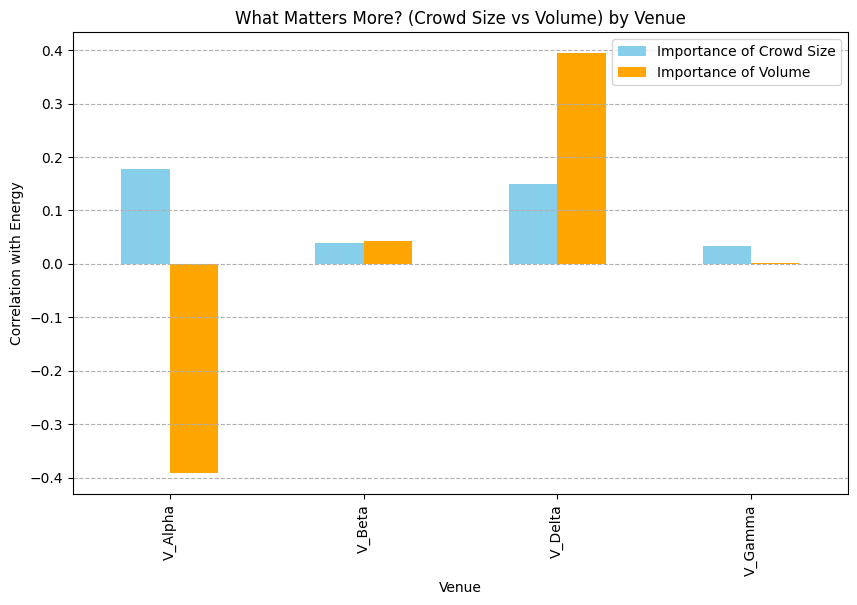

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

correlations = td.groupby("Venue_ID")[["Crowd_Size", "Volume_Level"]].corrwith(td["Crowd_Energy"])

correlations = correlations.rename(columns={
    "Crowd_Size": "Importance of Crowd Size",
    "Volume_Level": "Importance of Volume"
})

correlations.plot(kind='bar', figsize=(10, 6), color=["skyblue", "orange"])

plt.title("What Matters More? (Crowd Size vs Volume) by Venue")
plt.ylabel("Correlation with Energy")
plt.xlabel("Venue")
plt.grid(axis='y', linestyle='--')


plt.show()

**CONCLUSION**


From the above graph it is evident that depending on the venue both will show their affect on Crowd_Energy

2) **"Weekends are always better" vs "That Tuesday in London     was fire"**

   → **Are weekends USUALLY better or ALWAYS better?**

Average Energy by Day:
Day_of_Week_Name
Sunday       57.625445
Saturday     56.395468
Tuesday      52.581074
Thursday     52.558819
Monday       51.459561
Wednesday    50.988066
Friday       50.754045
Name: Crowd_Energy, dtype: float64


/tmp/ipython-input-3411216905.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Day_of_Week_Name", y="Crowd_Energy", data=td, order=day_order, palette="coolwarm")


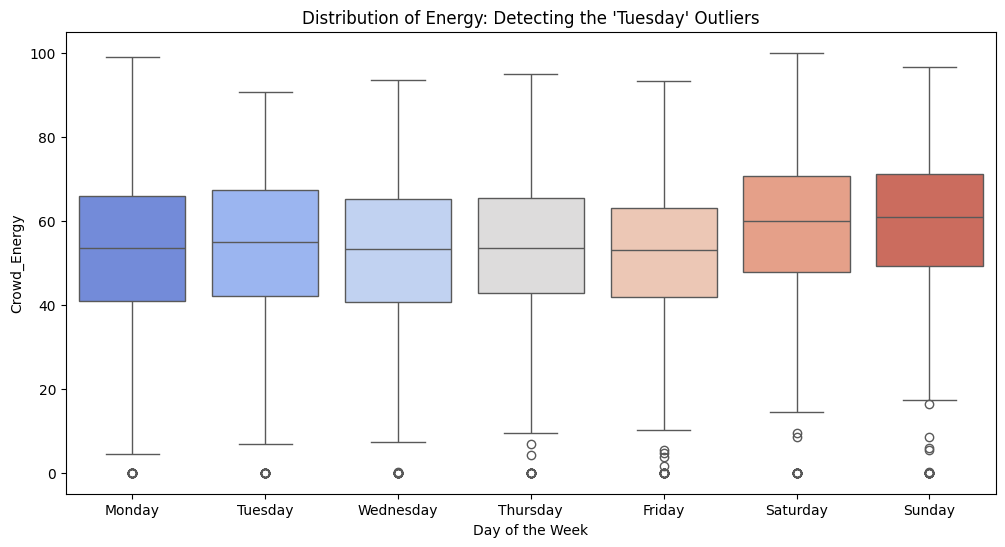

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
td['Day_of_Week_Name'] = td['Day_of_Week'].map(day_names)

print("Average Energy by Day:")
print(td.groupby('Day_of_Week_Name')['Crowd_Energy'].mean().sort_values(ascending=False))

plt.figure(figsize=(12, 6))

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.boxplot(x="Day_of_Week_Name", y="Crowd_Energy", data=td, order=day_order, palette="coolwarm")

plt.title("Distribution of Energy: Detecting the 'Tuesday' Outliers")
plt.xlabel("Day of the Week")
plt.show()

**Since the boxes have overlaps..**

**Weekends are NOT ALWAYS better(Mathematically)..**
**But yeah they are USUALLY better.**

*And you can see the line going from the tuesday box too high..So yeah that Tuesday in London was fire. *

**3)** **"Price sensitivity is at V_Gamma" vs "I remember a pricing thing at V_Delta"**

   → **Who actually cares about price? Everyone? Just snobs?**

<Figure size 1000x600 with 0 Axes>

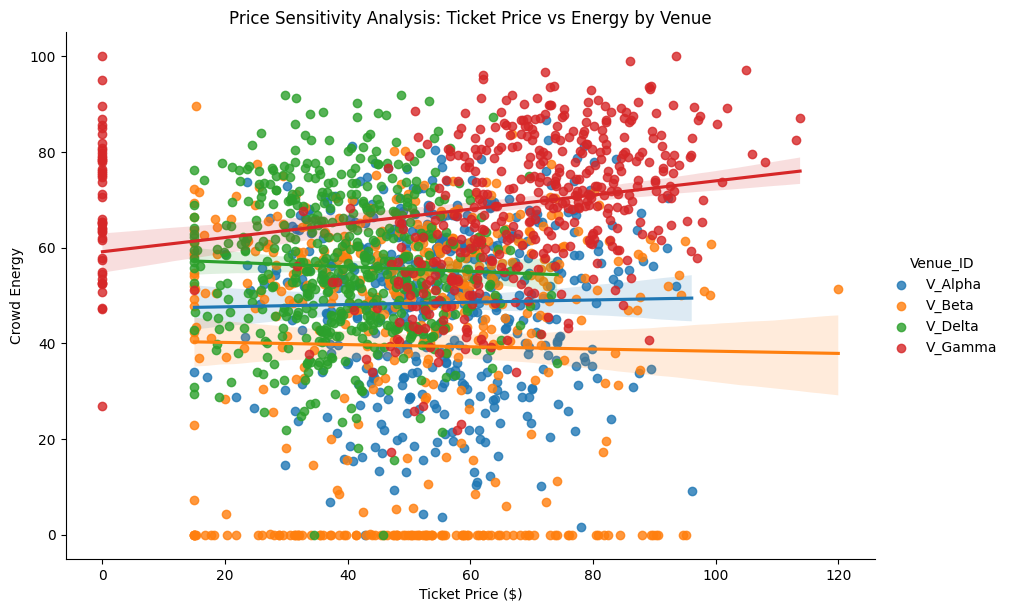

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
td['Ticket_Price_Clean'] = pd.to_numeric(td['Ticket_Price_Clean'], errors='coerce')

sns.lmplot(x="Ticket_Price_Clean", y="Crowd_Energy", hue="Venue_ID", data=td, height=6, aspect=1.5)

plt.title("Price Sensitivity Analysis: Ticket Price vs Energy by Venue")
plt.xlabel("Ticket Price ($)")
plt.ylabel("Crowd Energy")
plt.show()

Clearly By the regression lines that are drawn,

At  V_Gamma As ticket price increases crowd energy also increases..

At V_Delta As ticket price increases crowd energy decreases..

V_Alpha,V_Beta doesn't care about it.

**4. "Timing matters for goths" vs "Every venue has timing preferences"**

   → **Is V_Beta special or am I generalizing?**

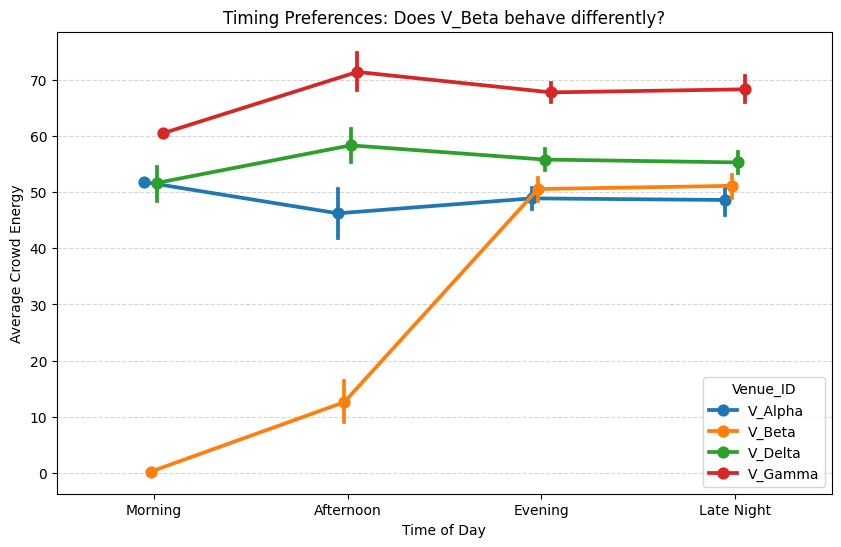

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

time_order = ["Morning", "Afternoon", "Evening","Late Night"]
sns.pointplot(x="Time_Label", y="Crowd_Energy", hue="Venue_ID",
              data=td, order=time_order, dodge=True)

plt.title("Timing Preferences: Does V_Beta behave differently?")
plt.xlabel("Time of Day")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Clearly from above point plot,

It can be seen that V_Beta is special

Timing matters the most for Goths...

**5. "Moon phase is real" vs "The drummer says I'm crazy"**

   → **VERIFY THIS. Prove him wrong.**


/tmp/ipython-input-3499411906.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Moon_Phase", y="Crowd_Energy", data=td, palette="viridis")


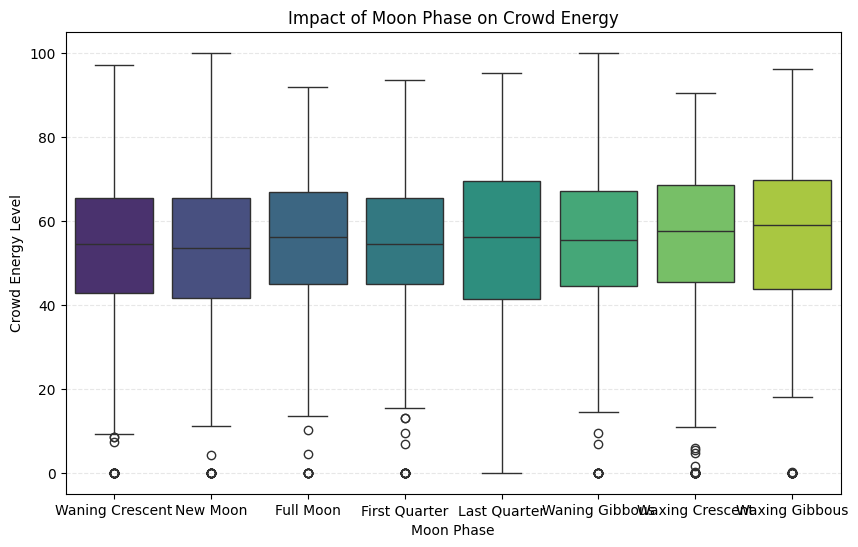

Average Energy by Phase:
Moon_Phase
Waxing Gibbous     54.887842
Waning Gibbous     54.110076
Waxing Crescent    53.535000
Full Moon          53.483198
Last Quarter       53.385000
First Quarter      52.897365
New Moon           52.092100
Waning Crescent    51.301435
Name: Crowd_Energy, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.boxplot(x="Moon_Phase", y="Crowd_Energy", data=td, palette="viridis")

plt.title("Impact of Moon Phase on Crowd Energy")
plt.xlabel("Moon Phase")
plt.ylabel("Crowd Energy Level")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

print("Average Energy by Phase:")
print(td.groupby("Moon_Phase")["Crowd_Energy"].mean().sort_values(ascending=False))

**Therefore it is clearly evident that  the Average Energy values for all the Moon_Phases are almost equal...**


**6. "Weather affects energy" vs "Weather affects MY mood"**

   → **Control for my mood somehow? Oh wait, you can't. Never mind.**


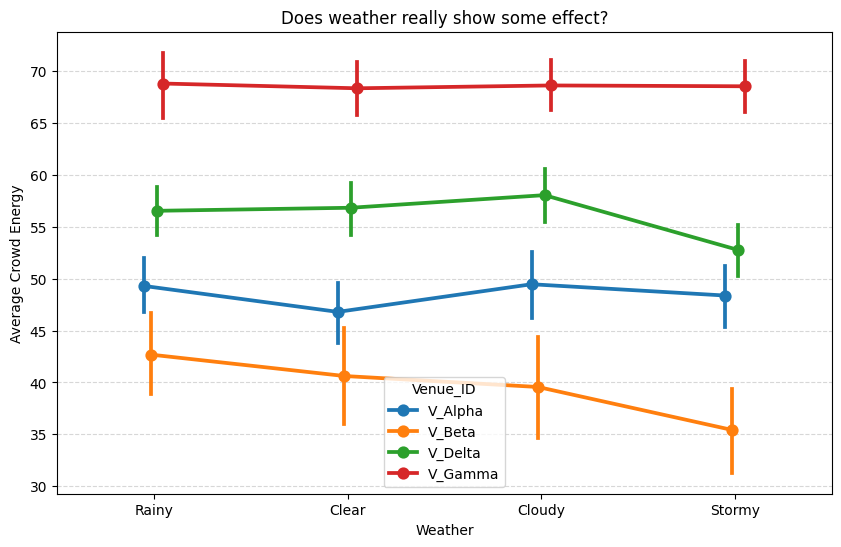

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Weather", y="Crowd_Energy", hue="Venue_ID",
              data=td, dodge=True)

plt.title("Does weather really show some effect?")
plt.xlabel("Weather")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Therefore only **Stormy** Weather matters and that too mainly for the venues **V_Beta** and **V_Delta**..

**To Escape Over_Fitting due to Weather column..Apply Feature Engineering here:**

In [ ]:
td["Is_Stormy"]=(td["Weather"]=="Stormy").astype(int)

## **To check whether Tuesday's are really Cursed ?**

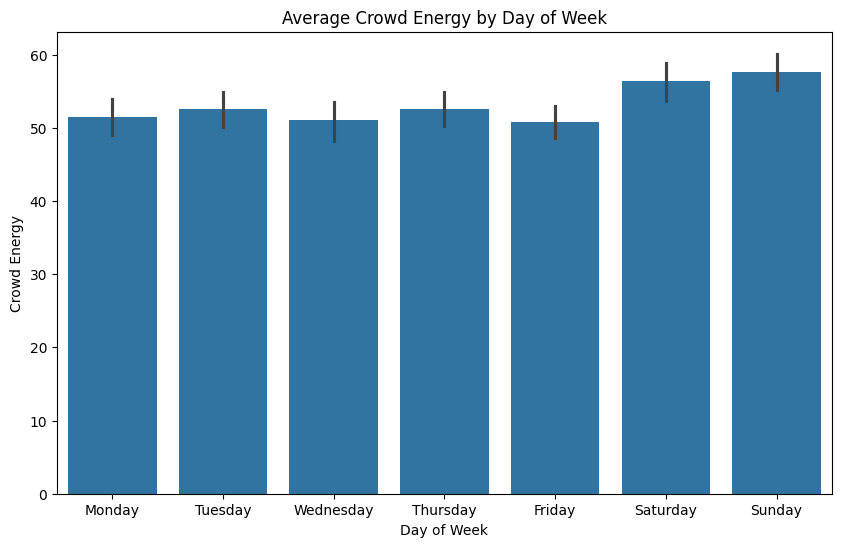

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

td['Day_of_Week_Name'] = pd.Categorical(td['Day_of_Week_Name'], categories=day_order, ordered=True)


plt.figure(figsize=(10, 6))
sns.barplot(x=td['Day_of_Week_Name'], y=td['Crowd_Energy'])
plt.title('Average Crowd Energy by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Crowd Energy')
plt.show()

**Clearly from the above bar graph it is evident that Tuesdays are not cursed..It is just a myth of the Singer.**

# **TO Know which venue has the Noise Limit:**

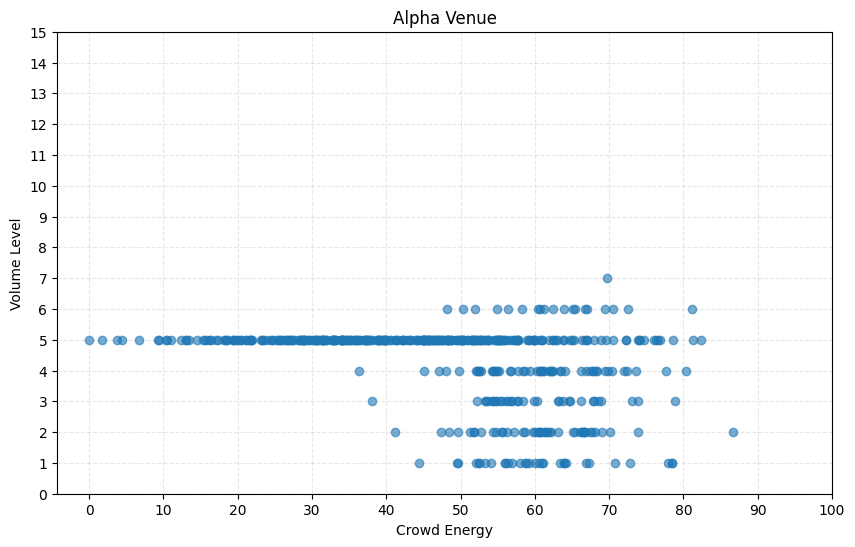

In [ ]:
import matplotlib.pyplot as plt

Volume_Alpha=td[(td["Venue_ID"]=="V_Alpha")&(td["Crowd_Energy"].notna())]["Volume_Level"]
Energy_Alpha=td[(td["Venue_ID"]=="V_Alpha") & (td["Crowd_Energy"].notna())]["Crowd_Energy"]

plt.figure(figsize=(10,6))
plt.plot(Energy_Alpha, Volume_Alpha, 'o', alpha=0.6)

plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 16, 1))

plt.grid(True, alpha=0.3, linestyle='--')
plt.title("Alpha Venue")
plt.xlabel("Crowd Energy")
plt.ylabel("Volume Level")

plt.show()

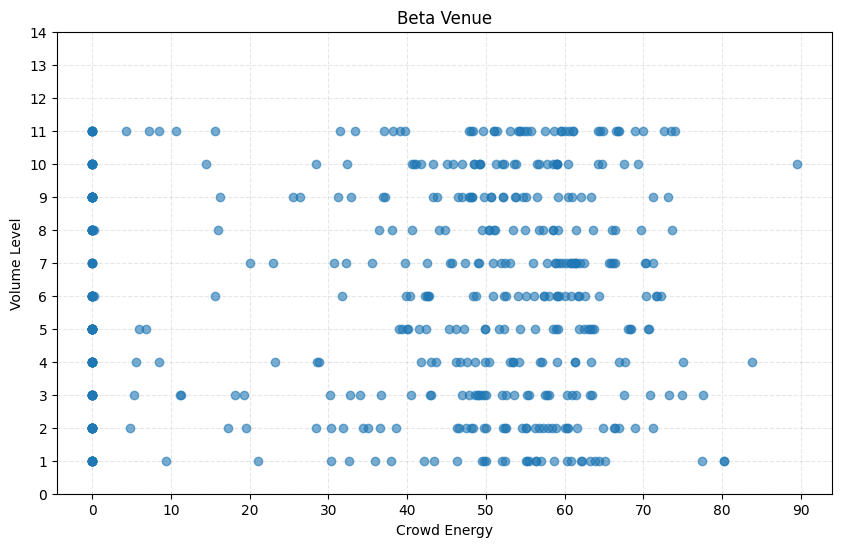

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Volume_Beta=td[(td["Venue_ID"]=="V_Beta")&(td["Crowd_Energy"].notna())]["Volume_Level"]
Energy_Beta=td[(td["Venue_ID"]=="V_Beta") & (td["Crowd_Energy"].notna())]["Crowd_Energy"]

plt.figure(figsize=(10,6))
plt.plot(Energy_Beta,Volume_Beta,'o',alpha=0.6)


plt.xticks(np.arange(0,100,10))
plt.yticks(np.arange(0,15,1))
plt.grid(True, alpha=0.3, linestyle='--')

plt.title("Beta Venue")
plt.xlabel("Crowd Energy")
plt.ylabel("Volume Level")

plt.show()

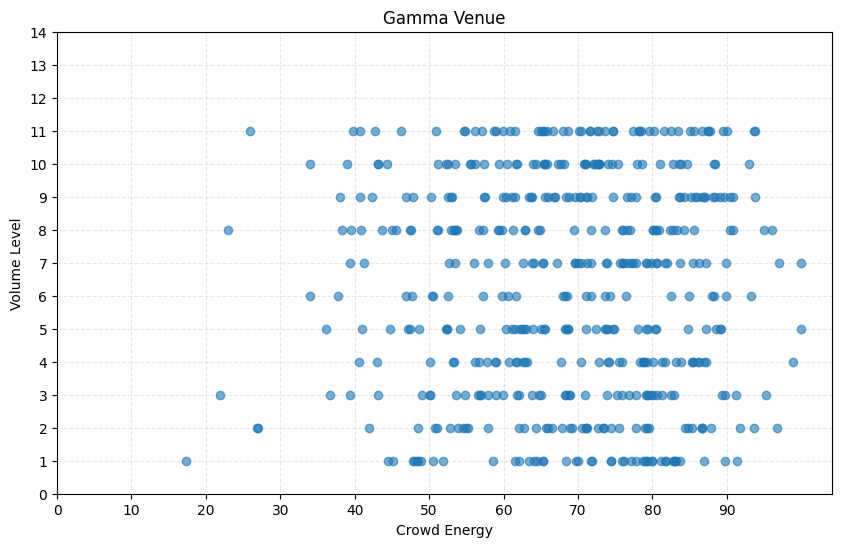

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Volume_Gamma=td[(td["Venue_ID"]=="V_Gamma")&(td["Crowd_Energy"].notna())]["Volume_Level"]
Energy_Gamma=td[(td["Venue_ID"]=="V_Gamma") & (td["Crowd_Energy"].notna())]["Crowd_Energy"]

plt.figure(figsize=(10,6))
plt.plot(Energy_Gamma,Volume_Gamma,'o',alpha=0.6)


plt.xticks(np.arange(0,100,10))
plt.yticks(np.arange(0,15,1))
plt.grid(True, alpha=0.3, linestyle='--')

plt.title("Gamma Venue")
plt.xlabel("Crowd Energy")
plt.ylabel("Volume Level")

plt.show()

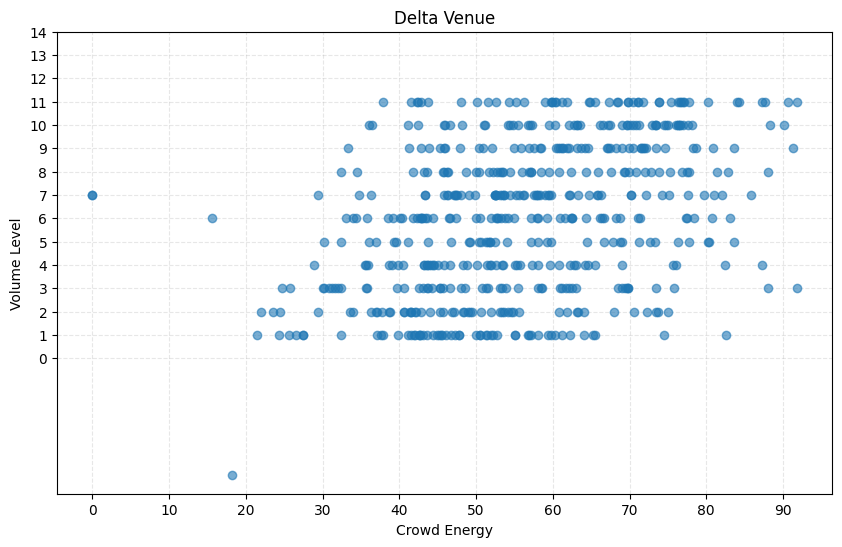

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Volume_Delta=td[(td["Venue_ID"]=="V_Delta")&(td["Crowd_Energy"].notna())]["Volume_Level"]
Energy_Delta=td[(td["Venue_ID"]=="V_Delta") & (td["Crowd_Energy"].notna())]["Crowd_Energy"]

plt.figure(figsize=(10,6))
plt.plot(Energy_Delta,Volume_Delta,'o',alpha=0.6)



plt.xticks(np.arange(0,100,10))
plt.yticks(np.arange(0,15,1))
plt.grid(True, alpha=0.3, linestyle='--')

plt.title("Delta Venue")
plt.xlabel("Crowd Energy")
plt.ylabel("Volume Level")

plt.show()

**Therefore from the above four venue wise graphs we can observe that V_Alpha has a soundlimit...**

# **Timing Analysis Of Each Venue**

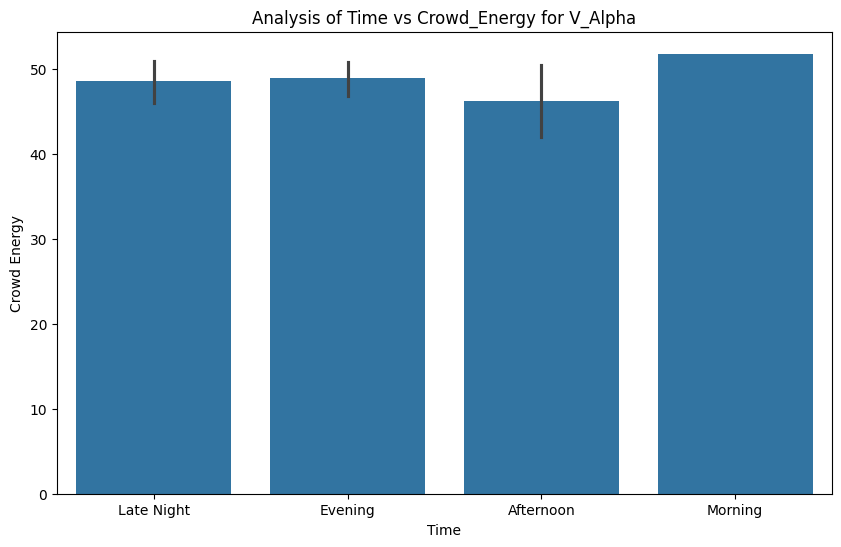

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Alpha"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Time_Label'], y=td['Crowd_Energy'])
plt.title('Analysis of Time vs Crowd_Energy for V_Alpha')
plt.xlabel('Time')
plt.ylabel('Crowd Energy')
plt.show()

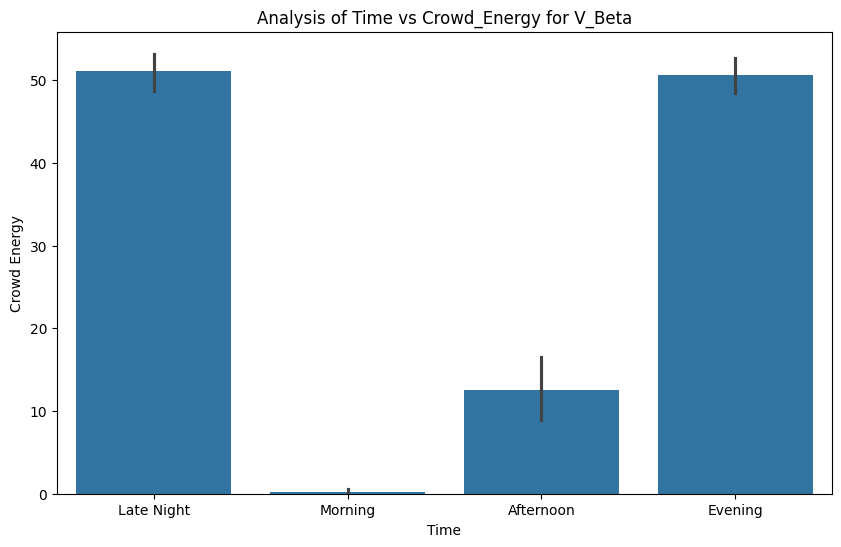

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Beta"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Time_Label'], y=td.loc[mask,'Crowd_Energy'])
plt.title('Analysis of Time vs Crowd_Energy for V_Beta')
plt.xlabel('Time')
plt.ylabel('Crowd Energy')
plt.show()

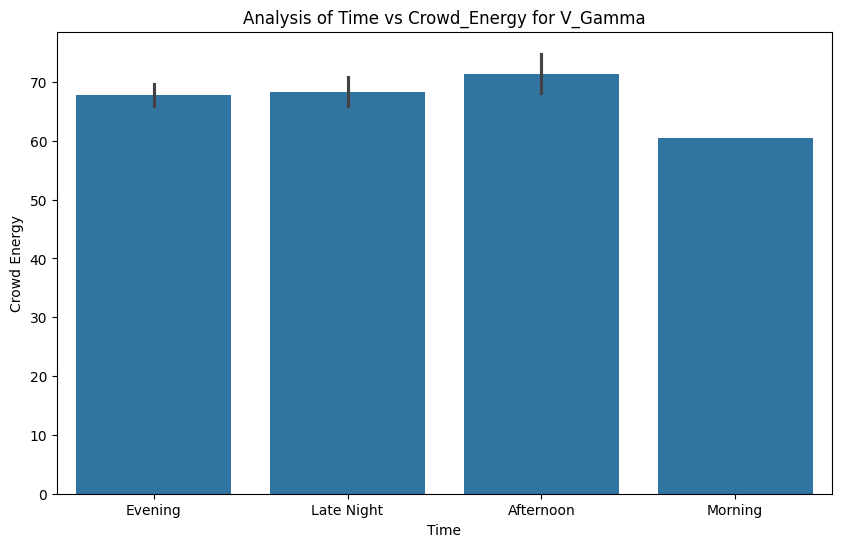

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Gamma"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Time_Label'], y=td.loc[mask,'Crowd_Energy'])
plt.title('Analysis of Time vs Crowd_Energy for V_Gamma')
plt.xlabel('Time')
plt.ylabel('Crowd Energy')
plt.show()

In [ ]:

afternoon_data = td[td['Time_Label'] == 'Afternoon']


max_crowd_energy_by_venue = afternoon_data.groupby('Venue_ID')['Crowd_Energy'].max()

venue_max_afternoon_energy = max_crowd_energy_by_venue.idxmax()
max_energy_value = max_crowd_energy_by_venue[venue_max_afternoon_energy]

print(f"The venue with the maximum crowd energy in the 'Afternoon' is '{venue_max_afternoon_energy}' with a value of {max_energy_value:.2f}")

The venue with the maximum crowd energy in the 'Afternoon' is 'V_Gamma' with a value of 96.08


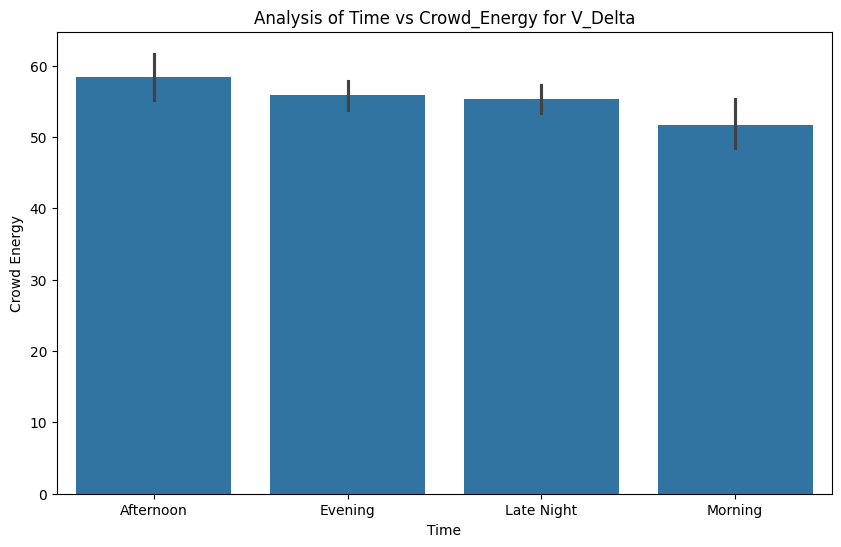

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Delta"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Time_Label'], y=td.loc[mask,'Crowd_Energy'])
plt.title('Analysis of Time vs Crowd_Energy for V_Delta')
plt.xlabel('Time')
plt.ylabel('Crowd Energy')
plt.show()

So we can see that V_Beta is better only at Nights...

And yeah Afternoons are better at V_Gamma..

# **Does Moon_Phase really affect the show?**

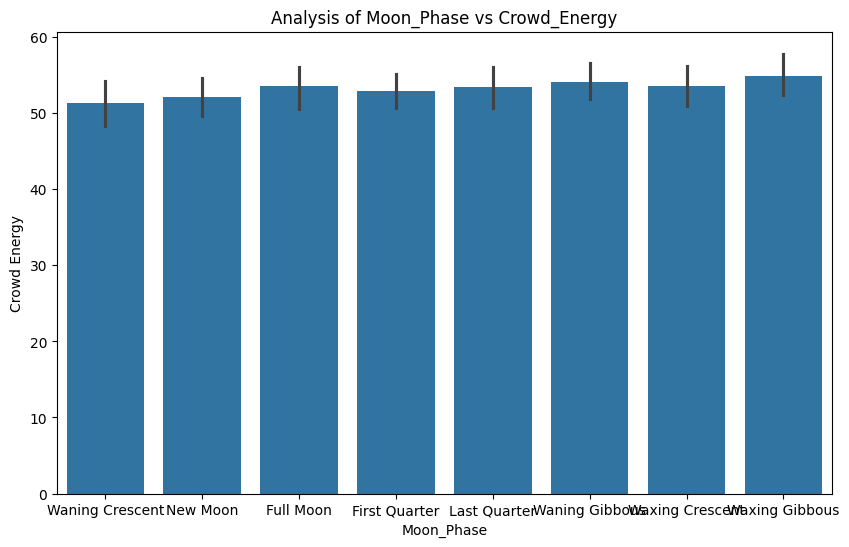

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.barplot(x=td['Moon_Phase'], y=td['Crowd_Energy'])
plt.title('Analysis of Moon_Phase vs Crowd_Energy')
plt.xlabel('Moon_Phase')
plt.ylabel('Crowd Energy')
plt.show()


**Clearly The Moon_Phase doesnt matter...**

**Its just a superstition of the Singer.**


# **Does Outfit relate to Crowd_Energy?**

# Venue Wise Analysis :

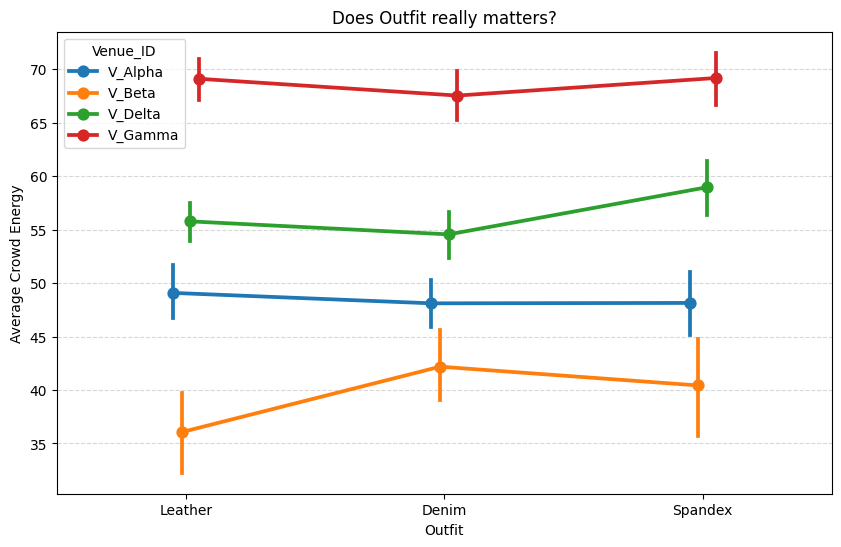

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Band_Outfit", y="Crowd_Energy", hue="Venue_ID",
              data=td, dodge=True)

plt.title("Does Outfit really matters?")
plt.xlabel("Outfit")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Therefore it is evident that all outfits show almost equal levels..

So outfit doesn't really matter much..





# **Does Weather affect the Crowd_Energy ? :**

# Venue Wise Analysis :

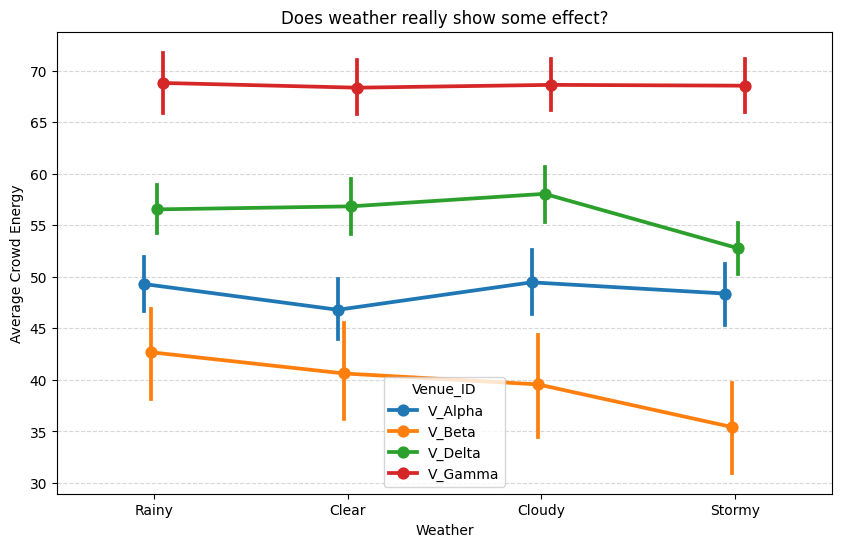

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Weather", y="Crowd_Energy", hue="Venue_ID",
              data=td, dodge=True)

plt.title("Does weather really show some effect?")
plt.xlabel("Weather")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Therefore it is clear that Stormy weather affects **V_Alpha and V_Delta**..It reduces Crowd_Energy there..

# **How Ticket Price affect Crowd_Energy..!**

# Venue Wise Analysis :

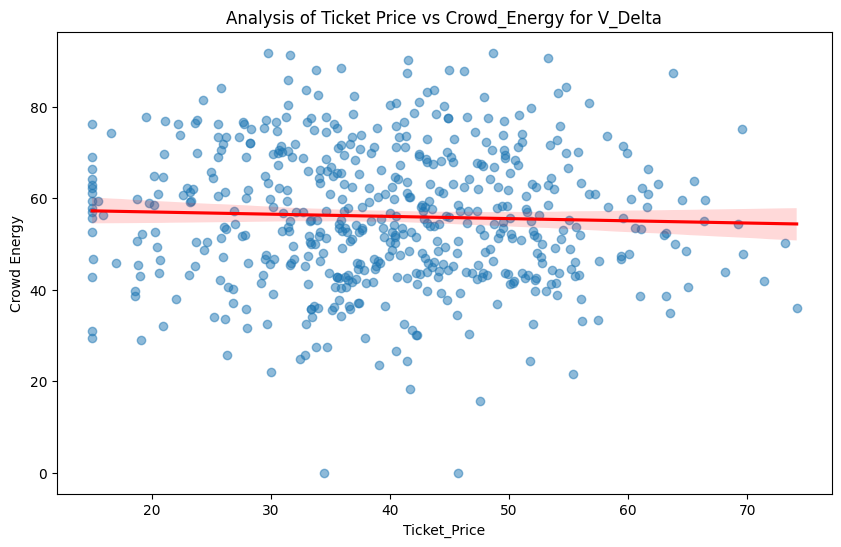

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=(td["Venue_ID"]=="V_Delta")&(td["Ticket_Price_Clean"]>0)

plt.figure(figsize=(10, 6))
sns.regplot(x=td.loc[mask,'Ticket_Price_Clean'], y=td.loc[mask,'Crowd_Energy'],scatter_kws={'alpha':0.5},line_kws={'color':'red'})
plt.title('Analysis of Ticket Price vs Crowd_Energy for V_Delta')
plt.xlabel('Ticket_Price')
plt.ylabel('Crowd Energy')
plt.show()

Therefore **V_Delta** is **negatively** effected by the **increase** in price

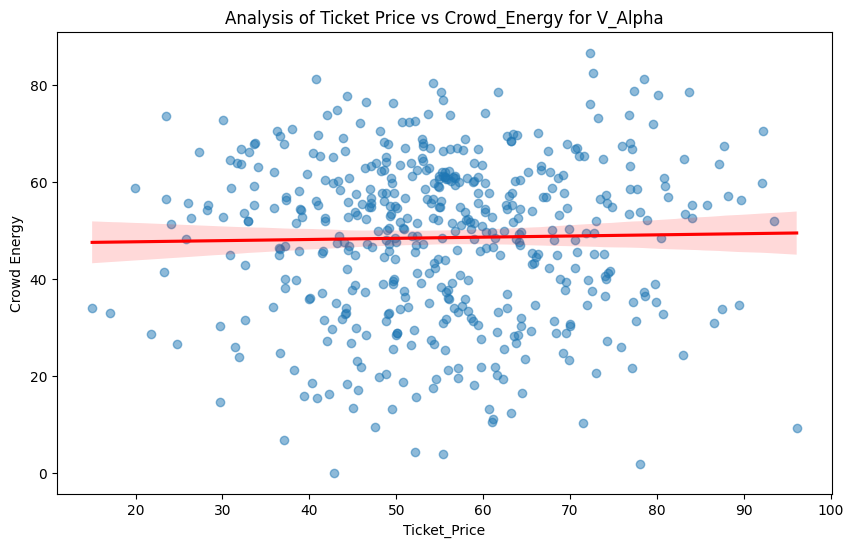

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

td['Ticket_Price_Clean'] = pd.to_numeric(td['Ticket_Price_Clean'], errors='coerce')
mask=(td["Venue_ID"]=="V_Alpha")&(td["Ticket_Price_Clean"]>0)

plt.figure(figsize=(10, 6))
sns.regplot(x=td.loc[mask,'Ticket_Price_Clean'], y=td.loc[mask,'Crowd_Energy'],scatter_kws={'alpha':0.5},line_kws={'color':'red'})
plt.title('Analysis of Ticket Price vs Crowd_Energy for V_Alpha')
plt.xlabel('Ticket_Price')
plt.ylabel('Crowd Energy')
plt.show()

Ticket Price has almost **no affect** on **V_Alpha...**

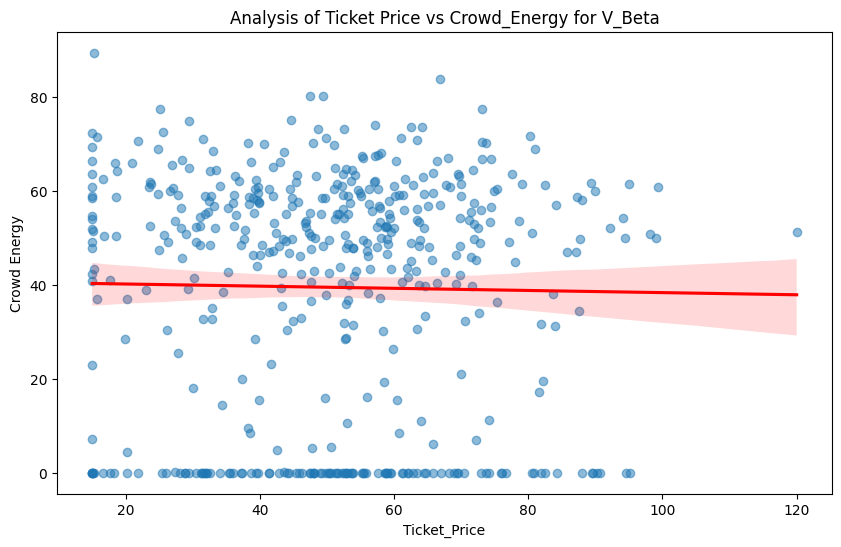

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

td['Ticket_Price_Clean'] = pd.to_numeric(td['Ticket_Price_Clean'], errors='coerce')
mask=(td["Venue_ID"]=="V_Beta")&(td["Ticket_Price_Clean"]>0)

plt.figure(figsize=(10, 6))
sns.regplot(x=td.loc[mask,'Ticket_Price_Clean'], y=td.loc[mask,'Crowd_Energy'],scatter_kws={'alpha':0.5},line_kws={'color':'red'})
plt.title('Analysis of Ticket Price vs Crowd_Energy for V_Beta')
plt.xlabel('Ticket_Price')
plt.ylabel('Crowd Energy')
plt.show()

**V_Beta** has almost **no** affect wrt price

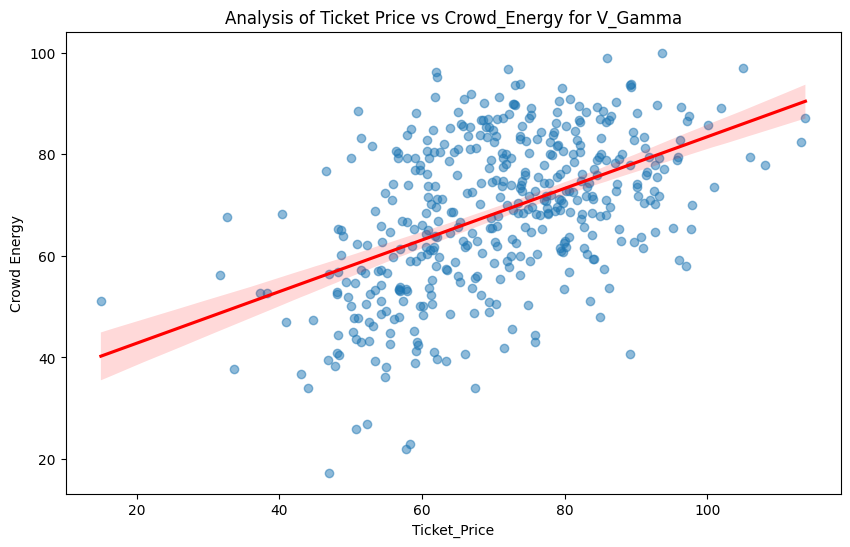

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

td['Ticket_Price_Clean'] = pd.to_numeric(td['Ticket_Price_Clean'], errors='coerce')
mask=(td["Venue_ID"]=="V_Gamma")&(td["Ticket_Price_Clean"]>0)

plt.figure(figsize=(10, 6))
sns.regplot(x=td.loc[mask,'Ticket_Price_Clean'], y=td.loc[mask,'Crowd_Energy'],scatter_kws={'alpha':0.5},line_kws={'color':'red'})
plt.title('Analysis of Ticket Price vs Crowd_Energy for V_Gamma')
plt.xlabel('Ticket_Price')
plt.ylabel('Crowd Energy')
plt.show()

There is a drastic **increase** in Crowd_Energy with Price in **V_Gamma**..

# **CALCULATING THE CORRELATION VALUE :**

In [ ]:
import pandas as pd

td['Ticket_Price_Clean'] = pd.to_numeric(td['Ticket_Price_Clean'], errors='coerce')

venue_correlations = {}

for venue in td['Venue_ID'].unique():

    mask = (td['Venue_ID'] == venue) & (td['Crowd_Energy'].notna())

    venue_data = td.loc[mask]

    correlation = venue_data['Ticket_Price_Clean'].corr(venue_data['Crowd_Energy'])
    venue_correlations[venue] = correlation

cr_df = pd.DataFrame(venue_correlations.items(), columns=['Venue_ID', 'Correlation'])

cr_df = cr_df.sort_values(by='Correlation', ascending=True)
cr_df
print("Correlation between Ticket Price and Crowd Energy by Venue:")
cr_df = cr_df[cr_df['Venue_ID'] != 531.0]
display(cr_df)

Correlation between Ticket Price and Crowd Energy by Venue:


,Venue_ID,Correlation
2,V_Delta,-0.039013
1,V_Beta,-0.017899
0,V_Alpha,0.020737
3,V_Gamma,0.246877


# **Effect of Crowd_Size on Crowd_Energy For Each Venue :**

<Figure size 1000x600 with 0 Axes>

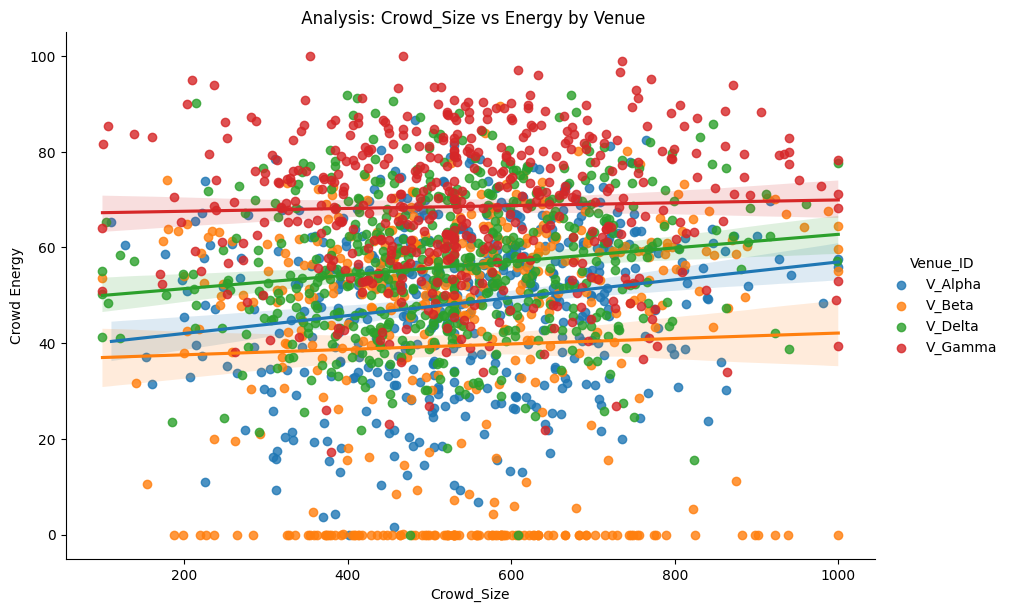

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
td['Crowd_Size'] = pd.to_numeric(td['Crowd_Size'], errors='coerce')

sns.lmplot(x="Crowd_Size", y="Crowd_Energy", hue="Venue_ID", data=td, height=6, aspect=1.5)

plt.title(" Analysis: Crowd_Size vs Energy by Venue")
plt.xlabel("Crowd_Size")
plt.ylabel("Crowd Energy")
plt.show()

In [ ]:

correlation_per_venue = td.groupby("Venue_ID")[["Crowd_Energy", "Crowd_Size"]].corr(method="spearman")

print(correlation_per_venue)

                       Crowd_Energy  Crowd_Size
Venue_ID                                       
V_Alpha  Crowd_Energy      1.000000    0.185074
         Crowd_Size        0.185074    1.000000
V_Beta   Crowd_Energy      1.000000    0.076036
         Crowd_Size        0.076036    1.000000
V_Delta  Crowd_Energy      1.000000    0.163797
         Crowd_Size        0.163797    1.000000
V_Gamma  Crowd_Energy      1.000000    0.056029
         Crowd_Size        0.056029    1.000000


At **V_Alpha** and **V_Delta** Crowd_Energy increases with increase in Crowd..

At **V_Gamma** and **V_Beta** no much slope can be seen..

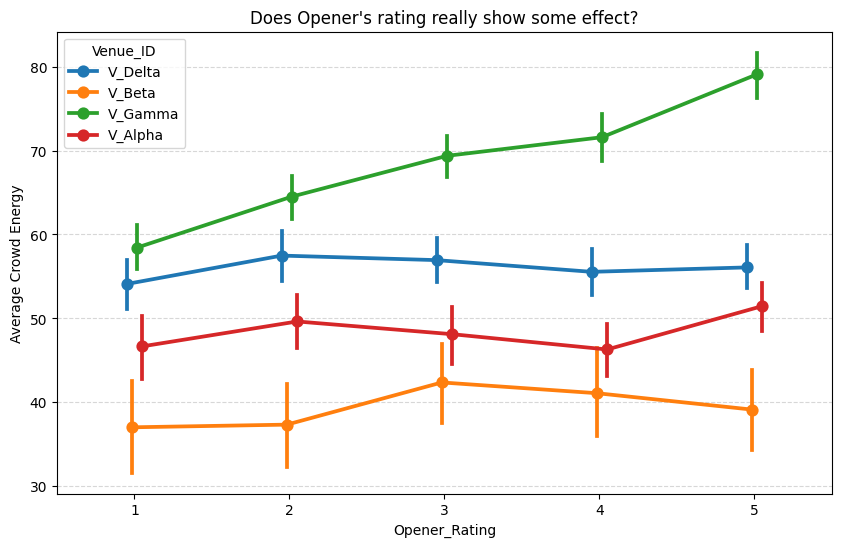

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Opener_Rating", y="Crowd_Energy", hue="Venue_ID",
              data=td, dodge=True)

plt.title("Does Opener's rating really show some effect?")
plt.xlabel("Opener_Rating")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
cr_op_r= td.groupby("Venue_ID")[["Crowd_Energy", "Opener_Rating"]].corr(method="spearman")

print(cr_op_r)

                        Crowd_Energy  Opener_Rating
Venue_ID                                           
V_Alpha  Crowd_Energy       1.000000       0.040525
         Opener_Rating      0.040525       1.000000
V_Beta   Crowd_Energy       1.000000       0.031386
         Opener_Rating      0.031386       1.000000
V_Delta  Crowd_Energy       1.000000       0.025347
         Opener_Rating      0.025347       1.000000
V_Gamma  Crowd_Energy       1.000000       0.472434
         Opener_Rating      0.472434       1.000000


Clearly it is evident that opener's rating matters the **most** for **V_Gamma**...


And **V_Delta** **doesnt care** about the opener at all..

# **Dependence of Crowd_Energy on Volume_Level :**

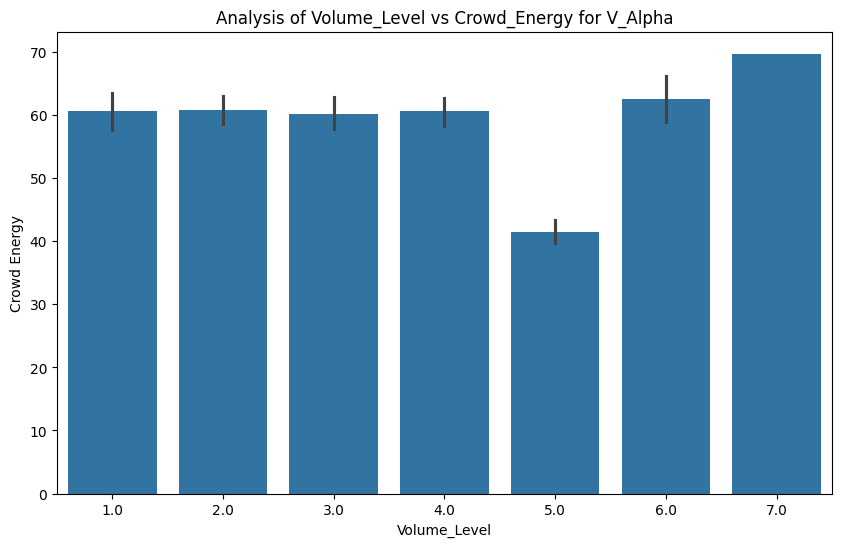

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Alpha"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Volume_Level'], y=td.loc[mask,'Crowd_Energy'])
plt.title('Analysis of Volume_Level vs Crowd_Energy for V_Alpha')
plt.xlabel('Volume_Level')
plt.ylabel('Crowd Energy')
plt.show()

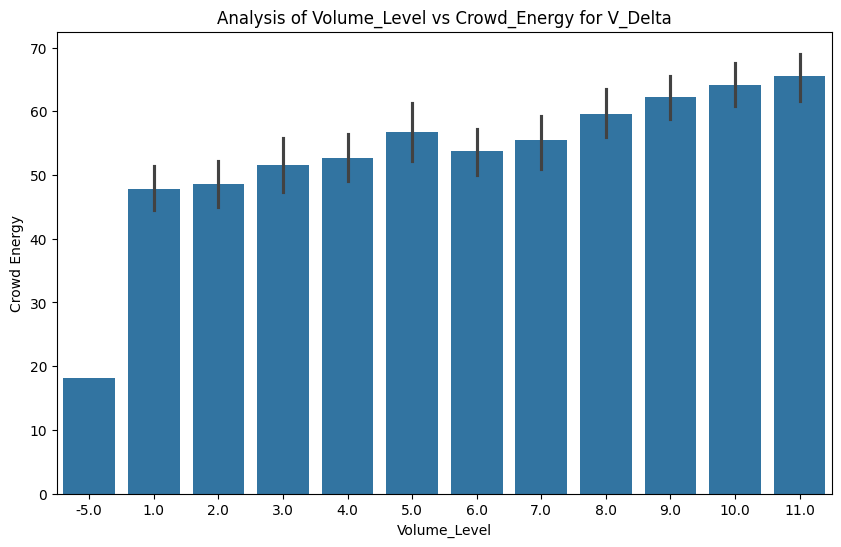

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

mask=td["Venue_ID"]=="V_Delta"

plt.figure(figsize=(10, 6))
sns.barplot(x=td.loc[mask,'Volume_Level'], y=td.loc[mask,'Crowd_Energy'])
plt.title('Analysis of Volume_Level vs Crowd_Energy for V_Delta')
plt.xlabel('Volume_Level')
plt.ylabel('Crowd Energy')
plt.show()

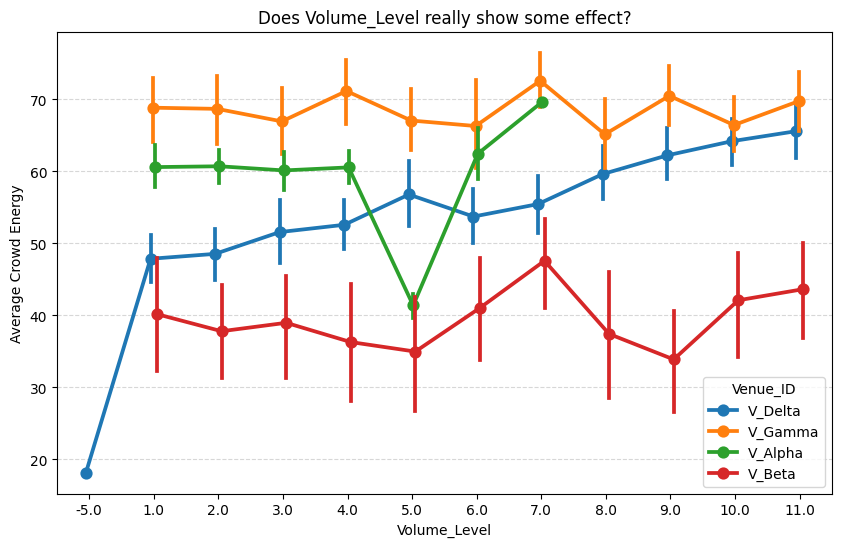

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Volume_Level", y="Crowd_Energy", hue="Venue_ID",
              data=td, dodge=True)

plt.title("Does Volume_Level really show some effect?")
plt.xlabel("Volume_Level")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

Therefore it is clear that **V_Delta** loves **Volume_Level** to a great extent..

# **Relation between Day_of_Week and Crowd_Energy: (Venue wise)**

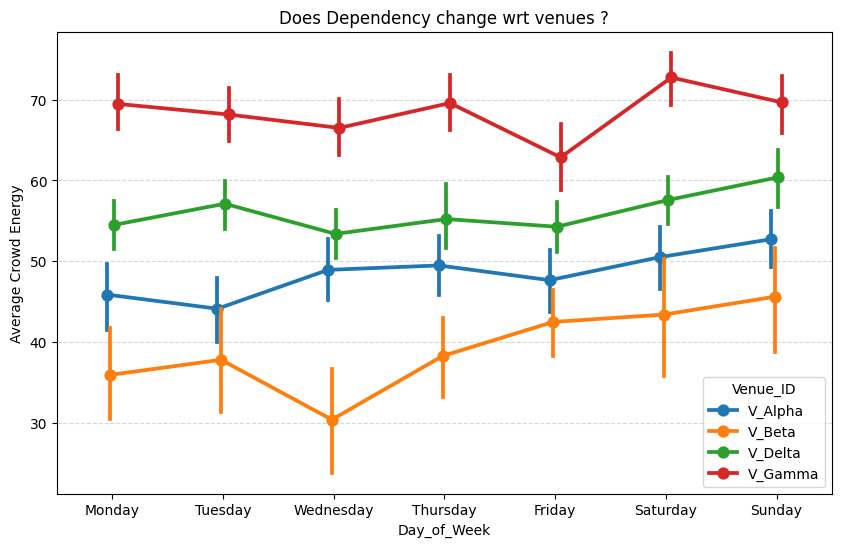

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.pointplot(x="Day_of_Week_Name", y="Crowd_Energy", hue="Venue_ID",
              data=td,  dodge=True)

plt.title("Does Dependency change wrt venues ?")
plt.xlabel("Day_of_Week")
plt.ylabel("Average Crowd Energy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

**Day matters the most for the V_Beta Venue..**

# **Overall Correlation matrix..**

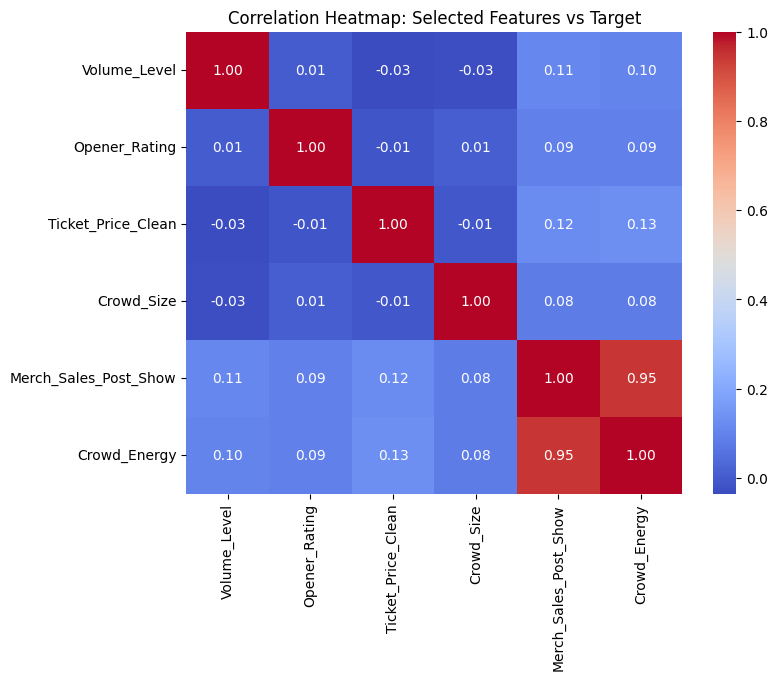

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_use = ["Volume_Level", "Opener_Rating","Ticket_Price_Clean","Crowd_Size","Merch_Sales_Post_Show","Crowd_Energy"]

subset_data = td[cols_to_use]

corr_matrix = subset_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Selected Features vs Target")
plt.show()

# **Model Training and HyperParameter Tuning :**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


time_mapping = {"Morning": 1, "Afternoon": 2, "Evening": 3, "Late Night": 4}
td['Time_Rank'] = td['Time_Label'].map(time_mapping).fillna(3)

features = [
    "Venue_ID",
    "Ticket_Price_Clean",
    "Crowd_Size",
    "Volume_Level",
    "Time_Rank",
    "Opener_Rating",
    "Day_of_Week_Name",
    "Is_Stormy"
]


data_ready = td.dropna(subset=["Crowd_Energy"])

X = pd.get_dummies(data_ready[features], columns=["Venue_ID", "Day_of_Week_Name"], drop_first=False)
y = data_ready["Crowd_Energy"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

default_rf = RandomForestRegressor(random_state=100)
default_rf.fit(X_train, y_train)

default_pred = default_rf.predict(X_test)
default_score = r2_score(y_test, default_pred)
print(f"Default Model Accuracy: {default_score:.4f}")


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


cv_strategy = KFold(n_splits=3, shuffle=True, random_state=100)

rf = RandomForestRegressor(random_state=100)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
tuned_pred = best_model.predict(X_test)
tuned_score = r2_score(y_test, tuned_pred)


print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Default Model R2: {default_score:.4f}")
print(f"Tuned Model R2:   {tuned_score:.4f}")



Default Model Accuracy: 0.5801
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Default Model R2: 0.5801
Tuned Model R2:   0.6283


# **Explanation:**

*MODEL SELECTION:*

      Among the models that I knew,I chose Randomforest over others(like LinearRegression and DecisionTrees)because
            1)Patterns largely depend on the Venue_ID..Therefore using a model like Linear Regression would not give accurate predictions.
            2)Since making different models for each venue is not much suggestable and it creates unneccesary chaos.
              I decided to make use of DecisionTrees..
             3)Since the features are diverse enough..
               We need to overcome the overfitting that a single DecisionTree might cause..
             4)Therefore keeping this in mind I decided to go with RANDOMFOREST.

# **CLEANING TEST DATA AND PREDICTIONS:**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving tour_logs_test_input.csv to tour_logs_test_input (5).csv


In [ ]:
ted=pd.read_csv("tour_logs_test_input.csv")

In [ ]:
import pandas as pd
import numpy as np
import re

ted["Show_DateTime_Clean"] = pd.to_datetime(
    ted["Show_DateTime"],
    errors="coerce"
)
m = ted["Show_DateTime_Clean"].isna()

ted.loc[m, "Show_DateTime_Clean"] = pd.to_datetime(
    ted.loc[m, "Show_DateTime"],
    format="%d/%m/%Y %I:%M %p",
    errors="coerce"
)
m2 = ted["Show_DateTime_Clean"].isna()

ted.loc[m2, "Show_DateTime_Clean"] = pd.to_datetime(
    ted.loc[m2, "Show_DateTime"],
    format="%m-%d-%Y %H:%M",
    errors="coerce"
)

ted["Show_Date"]=ted["Show_DateTime_Clean"].dt.date
ted["Show_Time"]=ted["Show_DateTime_Clean"].dt.time

ted["Time_Label"]=''
for i in range(len(ted)):
  x=ted.loc[i,"Show_DateTime"]
  y=ted.loc[i,"Show_DateTime_Clean"]

  if x in ["Morning","Afternoon","Evening","Late Night"]:
    ted.loc[i,"Time_Label"]=x

  elif pd.notnull(y):
    hour=y.hour

    if hour>=5 and hour<=11:
      ted.loc[i,"Time_Label"]="Morning"
    elif hour>=12 and hour<=16:
      ted.loc[i,"Time_Label"]="Afternoon"
    elif hour>=17 and hour<=20:
      ted.loc[i,"Time_Label"]="Evening"
    else:
      ted.loc[i,"Time_Label"]="Late Night"
  else:
    ted.loc[i,"Time_Label"]=None

beta_mode = ted[ted["Venue_ID"] == "V_Beta"]["Time_Label"].mode()[0]
mask = (ted["Venue_ID"] == "V_Beta") & (ted["Time_Label"].isna())
ted.loc[mask, "Time_Label"] = beta_mode

ex_rate = {
    "$": 1.0,
    "€": 1.09,
    "£": 1.27
}

ted["Ticket_Price_Clean"] = None

for i in ted.index:
    p = ted.loc[i, "Ticket_Price"]

    if pd.isnull(p):
        continue

    p = str(p)

    sym_chec = False
    amount = None

    for s in ex_rate:
        if s in p:
            sym_chec = True

            m = re.search(r'\d+\.?\d*', p)
            if m:
                amount = float(m.group()) * ex_rate[s]
            break

    if not sym_chec:
        m = re.search(r'\d+\.?\d*', p)
        if m:
            amount = float(m.group()) * ex_rate["$"]

    if amount is not None:
        ted.loc[i, "Ticket_Price_Clean"] = float(amount)
    if p=="Free":
        ted.loc[i, "Ticket_Price_Clean"] = 0.0

good_data_condition = (ted["Crowd_Size"] > 0) & (ted["Crowd_Size"] <= 1000)
valid_median = ted.loc[good_data_condition, "Crowd_Size"].median()

def clean_crowd_size(x):
    if x > 1000:
        return 1000
    elif x <= 0:
        return valid_median
    else:
        return x

ted["Crowd_Size"] = ted["Crowd_Size"].apply(clean_crowd_size)
ted["Crowd_Size"]= ted["Crowd_Size"].fillna(valid_median)

mask_alpha_volume = (
    (ted["Venue_ID"] == "V_Alpha") &
    (   (ted["Volume_Level"]>=11) |
        (ted["Volume_Level"].isna()) |
        (ted["Volume_Level"] <= 0)
    )
)
ted.loc[mask_alpha_volume,"Volume_Level"]=5

mask=(ted["Venue_ID"]!="V_Alpha")&((ted["Volume_Level"]==0) | (ted["Volume_Level"]>11) | (ted["Volume_Level"].isna()))
ted.loc[mask,"Volume_Level"]=11

ted["Is_Stormy"]=(ted["Weather"]=="Stormy").astype(int)

time_mapping = {"Morning": 1, "Afternoon": 2, "Evening": 3, "Late Night": 4}
ted['Time_Rank'] = ted['Time_Label'].map(time_mapping).fillna(3)

In [ ]:
ted.isnull().sum()

,0
Gig_ID,0
Venue_ID,0
Show_DateTime,0
Day_of_Week,0
Volume_Level,0
Ticket_Price,0
Crowd_Size,0
Opener_Rating,0
Weather,0
Moon_Phase,0


In [ ]:
import pandas as pd


day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
ted['Day_of_Week_Name'] = ted['Day_of_Week'].map(day_names)


features = [
    "Venue_ID",
    "Ticket_Price_Clean",
    "Crowd_Size",
    "Volume_Level",
    "Time_Rank",
    "Opener_Rating",
    "Day_of_Week_Name",
    "Is_Stormy"
]


X_predict_raw = ted[features].copy()
X_predict_encoded = pd.get_dummies(X_predict_raw, columns=["Venue_ID", "Day_of_Week_Name"], drop_first=False)

X_predict_fin = X_predict_encoded.reindex(columns=X.columns, fill_value=0)

predns = best_model.predict(X_predict_fin)

output_df = pd.DataFrame({'Gig_ID': ted['Gig_ID'], 'Crowd_Energy': predns})

output_df.to_csv('predictions.csv', index=False)

display(output_df.head())

,Gig_ID,Crowd_Energy
0,Gig_0000,57.797379
1,Gig_0001,40.354092
2,Gig_0002,61.076113
3,Gig_0003,0.047209
4,Gig_0004,44.643659
